# Playing w/ Covid19 data in Python

In [1]:
#libraries
import requests as req
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime as dt
import datetime
from plotnine import *
import regex as re

## Functions to make working w/ data easier

### Calling the data from the API

In [2]:
#function to call api
def get_covid_api_json_data(area_type, area_code, measure):
    
    #define parameters
    parameters = {
        "areaType": area_type,
        "areaCode": area_code,
        "metric": measure,
        "format": "json"
    }
    
    #request
    response = req.get("https://api.coronavirus.data.gov.uk/v2/data", params = parameters)
    
    #make sure you got a response - stop if not, showing the code
    if response.status_code >= 400:
        return print(f"Response error {response.status_code}")
    
    #json
    response_json = response.json()
    
    #convert to df
    df = pd.json_normalize(
        response_json["body"], 
        record_path = [measure],
        meta = ["areaCode", "areaType", "areaName", "date", "metric"]
    )
    
    return df
    

### Processing the data

In [3]:
#function to group data into new age bands
def group_by_broad_age_bands(data):
    #start by setting 'case statements' for age groupings
    age_conditions = [
        data["age"].isin(["00_04", "05_09", "10_14", "15_19"]),
        data["age"].isin(["20_24", "25_29", "30_34", "35_39"]),
        data["age"].isin(["40_44", "45_49", "50_54", "55_59"]),
        data["age"].isin(["60_64", "65_69", "70_74", "75_79"]),
        data["age"].isin(["80_84", "85_89", "90+"]),
        data["age"].isin(["00_59", "60+", "unassigned"])
    ]
    
    age_choices = ["<20", "20 - 39", "40 - 59", "60 - 79", "80+", "Discard"]
    
    #add new age band
    data["broad_age"] = np.select(age_conditions, age_choices)
    #convert date to date format (currently string)
    data["date"] =  pd.to_datetime(data["date"])
    
    #work out min date for inclusion
    min_date = max(data["date"]) - datetime.timedelta(31)
    #filter dates
    data = data[data["date"] >= min_date]
    
    #wrangle the data
    grouped = (
        data.
        #filter out irrelevant ages
        query("age not in ['00_59', '60+', 'unassigned']").
        #create new age groups
        groupby(["areaName", "date", "broad_age"], as_index = False).
        agg({"rollingSum":"sum"})
    )
    
    #categorise broad age column
    grouped["broad_age"] = pd.Categorical(
        grouped["broad_age"],
        categories = ["<20", "20 - 39", "40 - 59", "60 - 79", "80+"],
        ordered = True
    )
    
    return grouped
    

### Plotting the data

In [4]:
#function to plot data using plotnine
def plot_covid_data(data):
    
    return (ggplot(data)
       #geoms
      + geom_col(aes(x = 'date', y = 'rollingSum', fill = "broad_age")) 
       #scales
       + scale_x_datetime(name = "Specimen date", date_breaks = "1 week")
       + scale_y_continuous(name = "Seven-day rolling sum of cases") 
       + scale_fill_discrete(name = "Age band")
       #labels
       +labs(
       title = f"Covid cases in {np.unique(data['areaName'])[0]}" 
       )
       #formatting
       + theme_minimal()
       + theme(
       axis_title = element_text(face = "bold"),
       legend_title = element_text(face = "bold")    
       )
      )
    

## Now try passing parameters through functions

In [5]:
#enter area codes for exeter and plymouth
area_codes = ["E07000041", "E06000026"]

#and now get the data for exeter and plymouth
raw_data = [get_covid_api_json_data("ltla", a, "newCasesBySpecimenDateAgeDemographics") for a in area_codes]

#check to see it looks right
raw_data[0].head(5)

,age,cases,rollingSum,rollingRate,areaCode,areaType,areaName,date,metric
0,00_04,0,0,0.0,ltla,E07000041,Exeter,2022-05-13,newCasesBySpecimenDateAgeDemographics
1,00_59,11,136,128.2,ltla,E07000041,Exeter,2022-05-13,newCasesBySpecimenDateAgeDemographics
2,05_09,0,0,0.0,ltla,E07000041,Exeter,2022-05-13,newCasesBySpecimenDateAgeDemographics
3,10_14,0,2,31.4,ltla,E07000041,Exeter,2022-05-13,newCasesBySpecimenDateAgeDemographics
4,15_19,0,5,53.5,ltla,E07000041,Exeter,2022-05-13,newCasesBySpecimenDateAgeDemographics


In [6]:
#now summarise the data
grouped_data = [group_by_broad_age_bands(d) for d in raw_data]

#have a look
grouped_data[1].head(5)

,areaName,date,broad_age,rollingSum
0,Plymouth,2022-04-12,20 - 39,380
1,Plymouth,2022-04-12,40 - 59,412
2,Plymouth,2022-04-12,60 - 79,267
3,Plymouth,2022-04-12,80+,50
4,Plymouth,2022-04-12,<20,109


## The results...

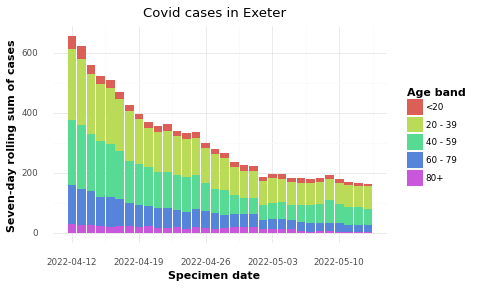

<ggplot: (91011840787)>

In [7]:
#stacked bar plot of cases over time - exeter

plot_covid_data(grouped_data[0])

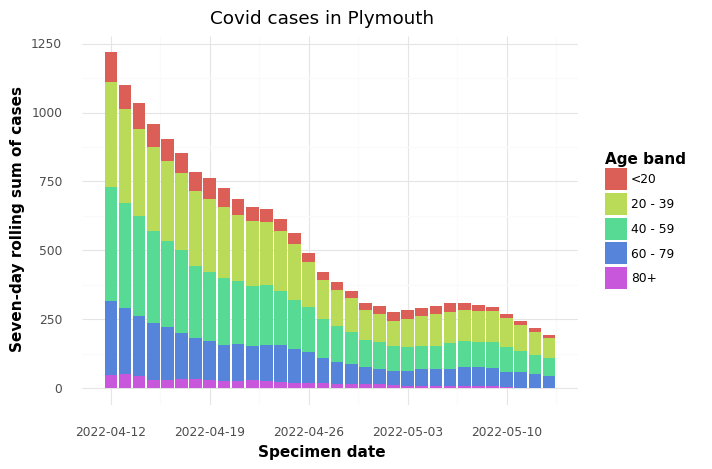

<ggplot: (91011620411)>

In [8]:
#now try plymouth - first get the data
plot_covid_data(grouped_data[1])
